In [13]:
#I follow this website to write code https://keras.io/keras_cv/
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_cv

from tensorflow import keras


In [14]:
BATCH_SIZE = 8

IMAGE_SIZE = (128, 128)

CLASSES = {
    1: "penguin",
    2: "turtle"
}

In [15]:
train_directory = "archive/train/train"
test_directory = "archive/valid/valid"

train_paths = sorted(os.path.join(train_directory, file) for file in os.listdir(train_directory))
print(train_paths)
test_paths =  sorted(os.path.join(test_directory, file) for file in os.listdir(test_directory))
print(test_paths)

['archive/train/train\\image_id_000.jpg', 'archive/train/train\\image_id_001.jpg', 'archive/train/train\\image_id_002.jpg', 'archive/train/train\\image_id_003.jpg', 'archive/train/train\\image_id_004.jpg', 'archive/train/train\\image_id_005.jpg', 'archive/train/train\\image_id_006.jpg', 'archive/train/train\\image_id_007.jpg', 'archive/train/train\\image_id_008.jpg', 'archive/train/train\\image_id_009.jpg', 'archive/train/train\\image_id_010.jpg', 'archive/train/train\\image_id_011.jpg', 'archive/train/train\\image_id_012.jpg', 'archive/train/train\\image_id_013.jpg', 'archive/train/train\\image_id_014.jpg', 'archive/train/train\\image_id_015.jpg', 'archive/train/train\\image_id_016.jpg', 'archive/train/train\\image_id_017.jpg', 'archive/train/train\\image_id_018.jpg', 'archive/train/train\\image_id_019.jpg', 'archive/train/train\\image_id_020.jpg', 'archive/train/train\\image_id_021.jpg', 'archive/train/train\\image_id_022.jpg', 'archive/train/train\\image_id_023.jpg', 'archive/train/

In [16]:
def preprocess_annotations(path):
    df = pd.read_json(path)
    return df

train_annotations = preprocess_annotations('archive/train_annotations')

test_annotations = preprocess_annotations('archive/valid_annotations')
train_annotations.head()

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,"[119, 25, 205, 606]",124230,[],0
1,1,1,1,"[131, 82, 327, 440]",143880,[],0
2,2,2,2,"[225, 298, 198, 185]",36630,[],0
3,3,3,2,"[468, 109, 172, 193]",33196,[],0
4,4,4,1,"[14, 242, 611, 154]",94094,[],0


In [17]:
inference_resizing  = keras_cv.layers.Resizing(
    *IMAGE_SIZE, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)
# data augmentation layers
augmenter = keras.Sequential(
    layers=[
        inference_resizing,
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    ]
)

In [27]:
def convert_img(path, label, bbox):
    return tf.image.decode_jpeg(tf.io.read_file(path)), label, bbox

def data_tran(image, label, bbox):
    # Convert to object detection format expected by Keras CV
    bounding_boxes = {"classes": [label],"boxes": [bbox],}
    return {"images": image, "bounding_boxes": bounding_boxes}

def date_generate(image_paths, annotations):
    slice_data = tf.data.Dataset.from_tensor_slices((image_paths,annotations["category_id"],annotations["bbox"].to_list()))
    data_i = slice_data.map(convert_img, num_parallel_calls=tf.data.AUTOTUNE)
    data_t =  data_i.map(data_tran, num_parallel_calls=tf.data.AUTOTUNE)
    data_raggeed = data_t.ragged_batch(BATCH_SIZE)
    resize_data = data_raggeed.map(lambda x: inference_resizing(x), num_parallel_calls=tf.data.AUTOTUNE)
    result = resize_data.prefetch(tf.data.AUTOTUNE)
    return result
    
    

train_dataset = date_generate(train_paths, train_annotations)
test_dataset = date_generate(test_paths, test_annotations)

print(train_dataset)
print(test_dataset)



<_PrefetchDataset element_spec={'images': TensorSpec(shape=(None, 128, 128, None), dtype=tf.float32, name=None), 'bounding_boxes': {'boxes': RaggedTensorSpec(TensorShape([None, None, 4]), tf.float32, 2, tf.int64), 'classes': RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64)}}>
<_PrefetchDataset element_spec={'images': TensorSpec(shape=(None, 128, 128, None), dtype=tf.float32, name=None), 'bounding_boxes': {'boxes': RaggedTensorSpec(TensorShape([None, None, 4]), tf.float32, 2, tf.int64), 'classes': RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64)}}>


In [28]:
from keras_cv.metrics import BoxCOCOMetrics
import tqdm
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = BoxCOCOMetrics(
            bounding_box_format="xywh",
      
            evaluate_freq=1e9,
        )
    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            y_pred = keras_cv.bounding_box.to_dense(y_pred, max_boxes=16)
            y_true = keras_cv.bounding_box.to_dense(y_true, max_boxes=16)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs

In [29]:
from keras.optimizers import SGD

model = keras_cv.models.RetinaNet(
    num_classes=2,
    bounding_box_format="xywh",
    backbone=keras_cv.models.ResNet50Backbone.from_preset(
            "resnet50_imagenet"
    )
)
    
base_lr = 0.005
optimizer = SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)
    
model.compile(
    classification_loss='focal',
    box_loss='smoothl1',
    optimizer=optimizer,
)

In [30]:
from keras_cv import bounding_box

def struc_transfer(data):
    return data["images"], bounding_box.to_dense(
        data["bounding_boxes"], max_boxes=32
    )


train_ds = train_dataset.map(struc_transfer, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = test_dataset.map(struc_transfer, num_parallel_calls=tf.data.AUTOTUNE)


history = model.fit(
    train_ds,
    epochs=20,
    callbacks=[EvaluateCOCOMetricsCallback(eval_ds)]
)


Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 0.9378 - box_loss: 0.6030 - classification_loss: 0.3348 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:09<00:00,  1.04s/it]

63/63 [==============================] - 87s 1s/step - loss: 0.9378 - box_loss: 0.6030 - classification_loss: 0.3348 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.0479 - MaP@[IoU=50]: 0.1735 - MaP@[IoU=75]: 5.1568e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0530 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0568 - Recall@[max_detections=10]: 0.1091 - Recall@[max_detections=100]: 0.1091 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1091 - Recall@[area=large]: 0.0000e+00


Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.6862 - box_loss: 0.4510 - classification_loss: 0.2352 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

63/63 [==============================] - 71s 1s/step - loss: 0.6862 - box_loss: 0.4510 - classification_loss: 0.2352 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.0326 - MaP@[IoU=50]: 0.1190 - MaP@[IoU=75]: 0.0127 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0345 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0857 - Recall@[max_detections=10]: 0.1250 - Recall@[max_detections=100]: 0.1250 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1296 - Recall@[area=large]: 0.0000e+00


Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.5151 - box_loss: 0.3514 - classification_loss: 0.1637 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.55it/s]

63/63 [==============================] - 71s 1s/step - loss: 0.5151 - box_loss: 0.3514 - classification_loss: 0.1637 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.0252 - MaP@[IoU=50]: 0.0763 - MaP@[IoU=75]: 0.0071 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0473 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.1734 - Recall@[max_detections=10]: 0.1844 - Recall@[max_detections=100]: 0.1844 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1967 - Recall@[area=large]: 0.0000e+00


Epoch 4/20
63/63 [==============================] - ETA: 0s - loss: 0.4290 - box_loss: 0.2821 - classification_loss: 0.1469 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.61it/s]

63/63 [==============================] - 71s 1s/step - loss: 0.4290 - box_loss: 0.2821 - classification_loss: 0.1469 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.1696 - MaP@[IoU=50]: 1.0000 - MaP@[IoU=75]: 0.0212 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1696 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.2786 - Recall@[max_detections=10]: 0.2786 - Recall@[max_detections=100]: 0.2786 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2786 - Recall@[area=large]: 0.0000e+00
Epoch 5/20


63/63 [==============================] - ETA: 0s - loss: 0.3747 - box_loss: 0.2529 - classification_loss: 0.1218 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:05<00:00,  1.61it/s]

63/63 [==============================] - 70s 1s/step - loss: 0.3747 - box_loss: 0.2529 - classification_loss: 0.1218 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.0059 - MaP@[IoU=50]: 0.0336 - MaP@[IoU=75]: 0.0022 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0279 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.1437 - Recall@[max_detections=10]: 0.1437 - Recall@[max_detections=100]: 0.1437 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1437 - Recall@[area=large]: 0.0000e+00


Epoch 6/20
63/63 [==============================] - ETA: 0s - loss: 0.3058 - box_loss: 0.2114 - classification_loss: 0.0944 - percent_boxes_matched_with_anchor: 0.9688

100%|██████████| 9/9 [00:06<00:00,  1.43it/s]

63/63 [==============================] - 72s 1s/step - loss: 0.3058 - box_loss: 0.2114 - classification_loss: 0.0944 - percent_boxes_matched_with_anchor: 0.9688 - MaP: 0.0378 - MaP@[IoU=50]: 0.1097 - MaP@[IoU=75]: 0.0144 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1068 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.2083 - Recall@[max_detections=10]: 0.2083 - Recall@[max_detections=100]: 0.2083 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2083 - Recall@[area=large]: 0.0000e+00
Epoch 7/20


39/63 [=================>............] - ETA: 27s - loss: 0.2521 - box_loss: 0.1809 - classification_loss: 0.0713 - percent_boxes_matched_with_anchor: 0.9688

In [32]:

from keras_cv import visualization
import cv2

inference_resizing = keras_cv.layers.Resizing(
    128, 128, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)



In [64]:


def predict_img(img_path):
    img = cv2.imread(img_path)
    img = [img]
    img = np.array(img)
    img = inference_resizing(img)
    prediction = model.predict(img)

# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
    visualization.plot_bounding_box_gallery(
        img,
        value_range=(0, 255),
        scale=5,
        cols=1,
        rows=1,
        show=True,
        font_scale=0.5,
        y_pred=prediction,
        bounding_box_format="xywh",
        class_mapping=CLASSES,
    )
    
    

    return prediction['classes'][0][0], list(prediction['boxes'][0][0] * 2.5)
print(predict_img('archive/valid/valid/image_id_000.jpg'))

1/1 [==============================] - 1s 1s/step
(1, [171.49306, 57.812862, 362.77786, 530.551])


In [43]:
# test Detection performance

import math

def cal_IOU(box_one, box_two):
    # bounding box 1  - (x_min, y_min, score, width, height, all in pixels)
    # bounding box 1  - (x_min, y_min, score, width, height, all in pixels)
    x_min_1 = box_one[0]
    y_min_1 = box_one[1]
    x_min_2 = box_two[0]
    y_min_2 = box_two[1]
    
    x_max_1 = box_one[0] + box_one[3]
    y_max_1 = box_one[1] + box_one[4]
    x_max_2 = box_two[0] + box_two[3]
    y_max_2 = box_two[1] + box_two[4]

    # calculate the intersection
    x_inter = max(0, min(x_max_1, x_max_2) - max(x_min_1, x_min_2))
    y_inter = max(0, min(y_max_1, y_max_2) - max(y_min_1, y_min_2))
    inter = x_inter * y_inter

    area_one = box_one[5]
    area_two = box_two[5]

    # calculate the union
    union = area_one + area_two - inter
    #IOU
    if union == 0:
        return 0
    return float(inter / union)

def cal_distance(true_box, predict_box):
    x_max_true = true_box[0] + true_box[2]
    y_max_true = true_box[1] + true_box[3]
    # find the center points of true boxes and predict boxes
    center_x_true = (true_box[0] + x_max_true)/2
    center_y_true = (true_box[1] + y_max_true)/2
    
    x_max_pre = predict_box[0] + predict_box[2]
    y_max_pre = predict_box[1] + predict_box[3]
    # find the center points of true boxes and predict boxes
    center_x_pre = (predict_box[0] + x_max_pre)/2
    center_y_pre = (predict_box[1] + y_max_pre)/2
    
    # calculate the distance
    distance = math.sqrt(abs(center_x_pre - center_x_true)**2 + abs(center_y_pre - center_y_true)**2)
    return distance


distance_dict = {}
distance_id = 0
distance_list = []
iou_list = []
test_img_path = 'archive/valid/valid'
test_annotations = preprocess_annotations('archive/valid_annotations')
for i_path in os.listdir(test_img_path):
    id = int(i_path.split('_')[2][0:3])
    true_bbox = test_annotations['bbox'][id]
    
    pre_box = predict_img('archive/valid/valid/' + i_path)[1]
    distance = cal_distance(true_bbox, pre_box)
    distance_dict[distance_id] = distance
    distance_id += 1
    distance_list.append(distance)
    
    true_bbox.insert(2,0)

    true_bbox.append(true_bbox[3] * true_bbox[4])
 
    pre_box.insert(2,0)
    pre_box.append(pre_box[3] * pre_box[4])

    iou = cal_IOU(true_bbox,pre_box)
    iou_list.append(iou)


1/1 [==============================] - 1s 906ms/step


In [44]:
print("mean of the distances: ", np.mean(distance_list))
print("standard deviation of the distances:", np.std(np.array(distance_list)))

print("mean of the iou: ", np.mean(iou_list))
print("standard deviation of the iou:", np.std(np.array(iou_list)))


mean of the distances:  149.91541377266074
standard deviation of the distances: 209.77676282423943
mean of the iou:  0.5000014094065798
standard deviation of the iou: 0.3199969305547923


In [45]:
# test Classification performance
classifier_dict = {}

id = 0
for i_path in os.listdir(test_img_path):
    
    pre_class = predict_img('archive/valid/valid/' + i_path)[0]
    classifier_dict[id] = pre_class
    id += 1

1/1 [==============================] - 1s 859ms/step


In [46]:
# 1 = penguin, 2 = turtle
print(classifier_dict)
index = 0
TP = 0
FP = 0
TN = 0
FN = 0
while index < len(classifier_dict):
    if classifier_dict[index] == 1:
        if int(classifier_dict[index]) == int(test_annotations['category_id'][index]):
            TP += 1
        else:
            FN += 1
    if classifier_dict[index] == 0:
        if int(classifier_dict[index]) == int(test_annotations['category_id'][index]):
            TN += 1
        else:
            FP += 1
    if classifier_dict[index] == -1:
        if int(test_annotations['category_id'][index]) == 1:
            FP += 1
        else: 
            FN += 1
        
    index += 1
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_score = 2 * (Precision * Recall) / (Precision + Recall)
Accuracy = (TP + TN)/(TP + FN + FP + TN)
print("Precision:" , Precision)
print("Recall: ", Recall)
print("F1_score: ",  F1_score)
print("Accuracy: ",  Accuracy)

{0: 1, 1: 0, 2: 0, 3: -1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 1, 10: -1, 11: 0, 12: 0, 13: -1, 14: 1, 15: -1, 16: 0, 17: 1, 18: -1, 19: 0, 20: 1, 21: -1, 22: 1, 23: 1, 24: 1, 25: 1, 26: -1, 27: -1, 28: -1, 29: 1, 30: -1, 31: 0, 32: 1, 33: 0, 34: -1, 35: 0, 36: 0, 37: 1, 38: -1, 39: -1, 40: -1, 41: 0, 42: 1, 43: 0, 44: -1, 45: 0, 46: 1, 47: 0, 48: 1, 49: 1, 50: -1, 51: -1, 52: 0, 53: 0, 54: 1, 55: 1, 56: 1, 57: 1, 58: -1, 59: -1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 0, 66: 0, 67: 0, 68: 1, 69: 1, 70: 0, 71: 0}
Precision: 0.8333333333333334
Recall:  0.6818181818181818
F1_score:  0.7499999999999999
Accuracy:  0.7222222222222222


In [47]:
def confusion_matrix(TP, TN, FP, FN):
    return np.array([[TP,FN],[FP,TN]])
print("confusion matrix: \n", confusion_matrix(TP, TN, FP, FN))

confusion matrix: 
 [[30 14]
 [ 6 22]]


1/1 [==============================] - 1s 866ms/step
23 87 539 454


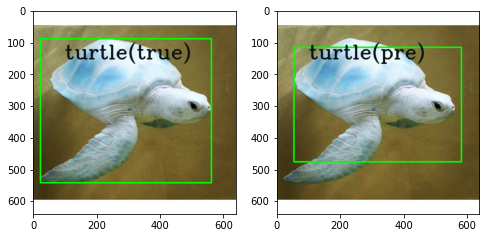

In [63]:
import cv2
nrows = 1
ncols = 2

font = cv2.FONT_HERSHEY_COMPLEX
color = (10,20,20)
def draw_img(img_path):

    col,row,width,height = predict_img(img_path)[1]
   
    img_pre = cv2.imread(img_path)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
    pre_word = ''
    if classifier_dict[int(img_path[-7:-4])] == 1:
        pre_word = 'penguin'
    if classifier_dict[int(img_path[-7:-4])] == 0:
        pre_word = 'turtle'
    pre_word_draw = pre_word + '(pre)'
    cv2.rectangle(img_pre, pt1=(int(col), int(row)), pt2=(int(col)+int(width), int(row)+int(height)), color=(0, 255, 0), thickness=4)
    cv2.putText(img_pre, pre_word_draw,(100,150),font,2, color,3)
        
    img_draw_true = cv2.imread(img_path)

    true_col = test_annotations['bbox'][int(img_path[-7:-4])][0]
    true_row = test_annotations['bbox'][int(img_path[-7:-4])][1]
    true_width = test_annotations['bbox'][int(img_path[-7:-4])][3]
    true_height = test_annotations['bbox'][int(img_path[-7:-4])][4]
    true_word = ''
    print(true_col,true_row,true_width,true_height)
    if int(test_annotations['category_id'][int(img_path[-7:-4])]) == 1:
        true_word = 'penguin'
    else:
        true_word = 'turtle'
    true_word_draw = true_word + '(true)'
    cv2.rectangle(img_draw_true, pt1=(true_col, true_row), pt2=(true_col+true_width, true_row+true_height), color=(0, 255, 0), thickness=4)
    cv2.putText(img_draw_true , true_word_draw,(100,150),font,2, color,3)

    axes[0].imshow(img_draw_true)
    axes[1].imshow(img_pre)
draw_img('archive/valid/valid/image_id_070.jpg')